In [1]:
from helpers import NormalizedEnv
from helpers import RandomAgent

import gym as gym
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn

import numpy as np
import random
random.seed(10)

from copy import deepcopy
from tqdm import tqdm
import importlib
# import warnings
# warnings.simplefilter("ignore")


#### 3 Heuristic policy
Define a simple heuristic policy to (attempt to) stabilize the pendulum. 
By comparing the heuristic policy with a random policy, verify that it leads to an increase in average reward.

In [2]:
# creating pendulum object
pendulum = gym.make('Pendulum-v1', g=9.81)
# wrapping pendulum to map output space to [-1,1]
pendulum = NormalizedEnv(pendulum)
# create random agent
Random_Agent = RandomAgent(pendulum)

In [3]:
def run_episode(agent = Random_Agent):
  """Execute one episode of an agent in the pendulum environment"""
  current_state = pendulum.reset()[0] # returns the initial state
  max_it = False
  i = 0
  total_reward = 0
  while not max_it:
    # The instructions state that trunc becomes True once max_it has been surpassed
    # The source code however outputs a False statically, hence this break section of code
    if i >= 200:
      max_it = True
      break
    action = agent.compute_action(state = current_state)
    transformed_action = pendulum.action(action) # maps an action to [-1, 1] interval
    next_state, reward, term, trunc, info = pendulum.step(transformed_action) 

    current_state = next_state
    total_reward += reward
    i += 1
  return total_reward

In [4]:
# execute 10 episodes with random agent to get an average cumulative reward
reward_vector_random_agent = []
for j in range(10):
  total_reward = run_episode()
  reward_vector_random_agent.append(total_reward)
  
print("The average cumulative reward obtained with random agent:", np.mean(reward_vector_random_agent))

c:\Users\User\anaconda3\envs\ann\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


The average cumulative reward obtained with random agent: -1274.1238603904453


In [5]:
class HeuristicPendulumAgent:
  """Heuristic policy for the pendulum"""
  def __init__(self, env, fixed_torque = 1):
    self.state_size = env.observation_space.shape[0]
    self.action_size = env.action_space.shape[0]
    self.fixed_torque = fixed_torque

  def compute_action(self, state):
    """Computes an action which indicates the torque to apply to the pendulum’s joint"""
    x, y, theta = state # x, y position and angular velocity
    if torch.is_tensor(state):
      action = np.zeros(len(x))
      for i in range(len(x)):
        if x[i] < 0:
          # the pendulum is in the lower half of the domain, 
          # applies a fixed torque in the same direction as the pendulum’s angular velocity
          action[i] = np.sign(theta[i])*self.fixed_torque
        else:
          # the pendulum is in the upper half of the domain,
          # applies a fixed torque in the opposite direction as the pendulum’s angular velocity
          action[i] = -np.sign(theta[i])*self.fixed_torque
    else:
      if x < 0:
        action = np.sign(theta)*self.fixed_torque
      else:
        action = -np.sign(theta)*self.fixed_torque

    return action

In [6]:
# execute 10 episodes with heuristic policy to get an average cumulative reward
heuristic_agent = HeuristicPendulumAgent(pendulum)
reward_vector_heuristic_agent = []

for j in range(10):
  total_reward = run_episode(agent = heuristic_agent)
  reward_vector_heuristic_agent.append(total_reward)
  
print("The average cumulative reward obtained with heuristic policy:",np.mean(reward_vector_heuristic_agent))

The average cumulative reward obtained with heuristic policy: -473.07563638041086


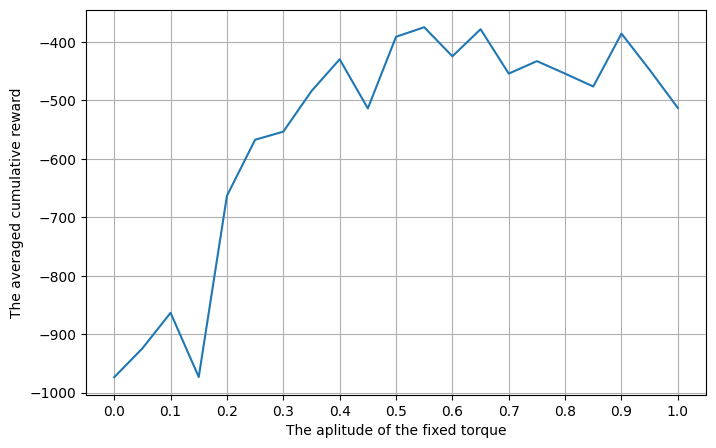

In [7]:
# effect of fixed torque amplitude on mean reward of 10 episodes (ten or one??)
reward_vector_heuristic_agent_varying_torque = []
torque = np.arange(0,1.05,0.05)
for t in torque:
  heuristic_agent = HeuristicPendulumAgent(pendulum, fixed_torque = t)
  reward_vector_heuristic_agent = []
  for j in range(10):
    total_reward = run_episode(agent = heuristic_agent)
    reward_vector_heuristic_agent.append(total_reward)
  reward_vector_heuristic_agent_varying_torque.append(np.mean(reward_vector_heuristic_agent))

plt.figure(figsize=(8,5))
plt.plot(torque, reward_vector_heuristic_agent_varying_torque)
plt.grid()

plt.xticks(np.arange(0,1.1,0.1))
plt.xlabel("The aplitude of the fixed torque")
plt.ylabel("The averaged cumulative reward")
plt.show()

#### 4 Q function of the heuristic policy
Implementation of the training procedure for the _critic_ – the Q network

In [8]:
class ReplayBuffer:
  def __init__(self, max_size = 200):
      """
          Createa a replay buffer which stores a sequence of transitions. 
          A transition is a tuple: (state, action, reward, next state, trunc).
          Is used to compute the 1-step TD-learning update rule.
          Variable trunc is a boolean that assumes a positive value after max steps (max_it).

          Parameters
          ----------
          max_size: int
              Max number of transitions to store in the buffer. When the buffer
              overflows the old memories are dropped.
          """
      self.num_exp=0
      self.buffer = []
      self.max_size = max_size # buffer size: how many transitions it can store at most

  def count(self):
      return self.num_exp
  
  def add_transition(self, state, action, reward, next_state, trunc):
      """Adds a new transition in the buffer."""
      transition = (state, action, reward, next_state, trunc)
      if self.num_exp < self.max_size:
          self.buffer.append(transition)
          self.num_exp +=1
      else:
          self.buffer.pop(0)
          self.buffer.append(transition)          

  def sample_transition(self, batch_size):
      """Samples a batch of experiences."""
      size = 0
      if self.num_exp < batch_size:
          size = self.num_exp
      else:
          size = batch_size
      
      batch_transitions=random.sample(self.buffer, size)
      state_batch, action_batch, reward_batch, next_state_batch, trunc = map(np.stack, zip(*batch_transitions))
      
      return state_batch, action_batch, reward_batch, next_state_batch, trunc
 


In [9]:
class QNetwork(nn.Module):
  # implementation of a fully-connected network with two layers
  def __init__(self):
    super().__init__()
    self.Lin1 = nn.Linear(4,32)
    self.Relu1 = nn.ReLU()
    self.Lin2 = nn.Linear(32,32)
    self.Relu2 = nn.ReLU()
    self.Lin3 = nn.Linear(32,1) # output a scalar value (the expected cumulative reward)

  def forward(self,x):
    x = self.Lin1(x)
    x = self.Relu1(x)
    x = self.Lin2(x)
    x = self.Relu2(x)
    x = self.Lin3(x)
    return x

In [10]:
device   = torch.device("cpu")
torch.manual_seed(-1)

MAX_IT = 200
BUFFER_SIZE = 1e4

BATCH_SIZE = 128
LEARNING_RATE = 1e-4
NUM_EPISODES = 1000
GAMMA = 0.99
MSE = nn.MSELoss()

In [11]:
heuristic_agent = HeuristicPendulumAgent(pendulum)
critic  = QNetwork().to(device) # critic
memory = ReplayBuffer(max_size=BUFFER_SIZE)
q_optimizer  = optim.Adam(critic.parameters(),  lr=LEARNING_RATE)

In [12]:
def onestepTD(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, agent, gamma, critic, iter):
    """1-step TD-learning rule"""                                 
    with torch.no_grad():
        action_next_state = agent.compute_action(state = next_state_batch.T)
        network_input_next_state = torch.cat((next_state_batch, torch.Tensor([action_next_state]).T), 1)
        q_next = critic(network_input_next_state) # should not be differentiated 

    if iter == MAX_IT:
        q_next = 0
    target_state = reward_batch + gamma * q_next # the last update in each episode should use q = 0 
    
    network_input_state = torch.cat((state_batch, action_batch),1)
    q = critic(network_input_state)

    q_optimizer.zero_grad()
    q_loss = MSE(target_state, q)
    q_loss.backward()
    q_optimizer.step()

    return q_loss

In [14]:
plot_reward = []
plot_policy = []
q_loss_plot = []

average_reward = 0
global_step = 0
nr_of_samples = 128

In [15]:
for episode in tqdm(range(NUM_EPISODES)):
    current_state = deepcopy(pendulum.reset()[0])

    ep_reward = 0.
    ep_q_value = 0.
    step = 0

    # collect experience
    for i in range(MAX_IT):
        action = heuristic_agent.compute_action(state = current_state)
        transformed_action = pendulum.action(action)
        next_state, reward, term, trunc, info = pendulum.step(transformed_action)

        memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

        if memory.count() > nr_of_samples:
            # sample a batch of transitions from the replay buffer
            state_batch, action_batch, reward_batch, next_state_batch, trunc_batch = memory.sample_transition(nr_of_samples)

            # converting to tensors
            state_batch = torch.FloatTensor(state_batch).to(device)
            action_batch = torch.FloatTensor(action_batch).unsqueeze(1).to(device)
            reward_batch = torch.FloatTensor(np.array(reward_batch)).unsqueeze(1).to(device) #.unsqueeze(1)
            trunc_batch = torch.Tensor(np.float32(trunc_batch)).unsqueeze(1).to(device)
            next_state_batch = torch.FloatTensor(next_state_batch).to(device)

            # 1-step TD-learning rule
            q_loss = onestepTD(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, heuristic_agent, GAMMA, critic, i)
                       
        
        current_state = deepcopy(next_state)
        ep_reward += reward
    try:
        #plot_reward.append([ep_reward, episode+1])
        # plot_q.append([q_loss.data, episode+1])
        q_loss_plot.append(q_loss.data)

        if (episode % 100 == 0):
            print(q_loss.item())
    except:
        continue


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_8072\3793136212.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  network_input_next_state = torch.cat((next_state_batch, torch.Tensor([action_next_state]).T), 1)
  0%|          | 1/1000 [00:02<45:13,  2.72s/it]

11.280699729919434


 10%|█         | 101/1000 [06:37<56:11,  3.75s/it] 

7.894444942474365


 20%|██        | 201/1000 [13:35<55:26,  4.16s/it]  

10.572893142700195


 30%|███       | 301/1000 [20:32<49:01,  4.21s/it]

22.218536376953125


 40%|████      | 401/1000 [27:26<41:17,  4.14s/it]

15.382098197937012


 50%|█████     | 501/1000 [34:23<34:46,  4.18s/it]

22.577598571777344


 60%|██████    | 601/1000 [41:23<27:57,  4.20s/it]

14.108935356140137


 70%|███████   | 701/1000 [48:23<20:47,  4.17s/it]

14.732841491699219


 80%|████████  | 801/1000 [55:23<14:00,  4.23s/it]

11.944069862365723


 90%|█████████ | 901/1000 [1:01:39<05:42,  3.46s/it]

15.94937515258789


100%|██████████| 1000/1000 [1:07:30<00:00,  4.05s/it]


Text(0, 0.5, 'MSE')

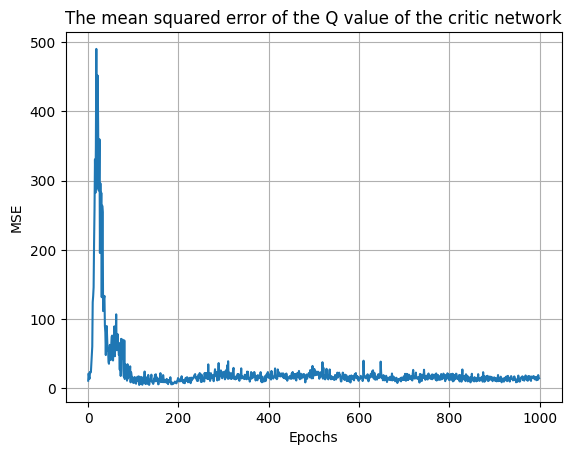

In [16]:
plt.plot(q_loss_plot)
plt.grid()
plt.title('The mean squared error of the Q value of the critic network')
plt.xlabel('Epochs')
plt.ylabel('MSE')

In [17]:
from HeatMap import *
# a polar heatmap for different values of the pendulum’s velocity and torque (action)

Velocity = [0,0,0,5,5]
Action = [0,2,-2,2,-2]

# each angle corresponds to the angular position of the pendulum
# the color corresponds to the magnitude of the q function

# TODO: two polar heatmap plots for each velocity and action pair, 
# one before and one after training the HeuristicPendulumAgent ??
Multiple_HeatMap(critic, Action, Velocity)

ModuleNotFoundError: No module named 'HeatMap'

#### 5 Minimal implementation of DDPG
Implementation of the first version of the DDPG algorithm: the actor network, the critic network, the action noise and the learning rule.

In [15]:
class PolicyNetwork(nn.Module):
  # actor
  def __init__(self):
    super().__init__()
    self.Lin1 = nn.Linear(3,32)
    self.Relu1 = nn.ReLU()
    self.Lin2 = nn.Linear(32,32)
    self.Relu2 = nn.ReLU()
    self.Lin3 = nn.Linear(32,1) # output a scalar value (the expected cumulative reward)
    self.Tanh = nn.Tanh()

  def forward(self,x):
    x = self.Lin1(x)
    x = self.Relu1(x)
    x = self.Lin2(x)
    x = self.Relu2(x)
    x = self.Lin3(x)
    x = self.Tanh(x)
    return x

In [16]:
class GaussianActionNoise():
    def __init__(self, std_deviation=1):
        self.std_deviation = std_deviation

    def get_noisy_action(self, action):
        """Adds noise to an input action, by summing it with a value sampled 
        from a Gaussian of a given standard deviation (std_deviation)"""
        
        noise = random.gauss(0, self.std_deviation)
        noisy_action = action + noise
        noisy_action = np.clip(noisy_action, -1., 1.)

        return noisy_action

In [17]:
class DDPGAgent:
    def __init__(self, policy_network, noisy_action):
        self.policy_network = policy_network
        self.noisy_action = noisy_action

    def compute_action(self, state, device, deterministic=True):
        """Processes an input state with the policy network and returns an action. 
        The parameter "deterministic" regulates whether to add random noise to the action or not"""
        
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.policy_network(state)

        if not deterministic:
            out = action.detach().cpu().numpy()[0]
            out = self.noisy_action.get_noisy_action(out)
        else:
            out = action[0]

        return out

    def update_target_params(self, network, target_network, Tau):
        for p_target, p in zip(target_network.parameters(), network.parameters()):
            p_target.data = Tau*p.data + (1-Tau)*p_target.data



In [18]:
NOISE_STD = 0.3

noise = GaussianActionNoise(NOISE_STD)

critic  = QNetwork().to(device) # critic
actor = PolicyNetwork().to(device) # policy_network

memory = ReplayBuffer(max_size=BUFFER_SIZE)
agent = DDPGAgent(actor, noise)

q_optimizer  = optim.Adam(critic.parameters(),  lr=LEARNING_RATE)
policy_optimizer  = optim.Adam(actor.parameters(),  lr=LEARNING_RATE)

In [19]:
def learning_policy(state_batch, policy_optimizer, actor, critic):
    """The learning rule for the policy network"""

    policy_optimizer.zero_grad()
    # does not use the ”on-trajectory” actions, 
    # which were computed by a previous version of the policy network, 
    # but computes them with the current actor (DDPG is an off-policy algorithm)
    policy_input_state = torch.cat((state_batch, actor(state_batch)), 1)
    policy_loss = -critic(policy_input_state)
    policy_loss = policy_loss.mean()
    policy_loss.backward()
    policy_optimizer.step()
    
    return policy_loss

In [20]:
reward_plot = []
policy_loss_plot = []
q_loss_plot = []

average_reward = 0
global_step = 0
nr_of_samples = 128

PRINT_EVERY = 50

for episode in tqdm(range(NUM_EPISODES)):
    current_state = deepcopy(pendulum.reset()[0])

    ep_reward = 0.
    ep_q_value = 0.
    step = 0

    # collect experience
    for i in range(MAX_IT):
        action = agent.compute_action(state = current_state, device=device, deterministic=False)
        action = action[0]

        next_state, reward, term, trunc, info = pendulum.step(action)

        memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

        if memory.count() > nr_of_samples:
            # sample a batch of transitions from the replay buffer
            state_batch, action_batch, reward_batch, next_state_batch, trunc_batch = memory.sample_transition(nr_of_samples)

            # converting to tensors
            state_batch = torch.FloatTensor(state_batch).to(device)
            action_batch = torch.FloatTensor(action_batch).unsqueeze(1).to(device)
            reward_batch = torch.FloatTensor(np.array(reward_batch)).unsqueeze(1).to(device)
            trunc_batch = torch.Tensor(np.float32(trunc_batch)).unsqueeze(1).to(device)
            next_state_batch = torch.FloatTensor(next_state_batch).to(device)

            # 1-step TD-learning rule                                 
            with torch.no_grad():
                action_next_state = agent.compute_action(state = next_state_batch, device=device)
                network_input_next_state = torch.cat((next_state_batch, torch.Tensor(action_next_state)),1)
                q_next = critic(network_input_next_state) # should not be differentiated 

            if iter == MAX_IT:
                q_next = 0
            target_state = reward_batch + GAMMA * q_next # the last update in each episode should use q = 0 
            
            network_input_state = torch.cat((state_batch, action_batch),1)
            q = critic(network_input_state)
    
            q_optimizer.zero_grad()
            q_loss = MSE(target_state, q)
            q_loss.backward()
            q_optimizer.step()

            policy_loss = learning_policy(state_batch, policy_optimizer, actor, critic)
            
        current_state = deepcopy(next_state)
        ep_reward += reward
    try:
        reward_plot.append(ep_reward)
        q_loss_plot.append(q_loss.data)
        policy_loss_plot.append(policy_loss.data)
        # plot_reward.append([ep_reward, episode+1])
        # plot_policy.append([policy_loss.data, episode+1])
        # plot_q.append([q_loss.data, episode+1])
        # plot_steps.append([step+1, episode+1])

    except:
        continue
    average_reward += ep_reward

    if (episode % PRINT_EVERY) == (PRINT_EVERY-1):    # print every print_every episodes
        print("Policy loss: ", policy_loss.data)
        print("Q loss: ", q_loss.data)
        print("Episode reward: ", ep_reward)
        #subplot(plot_reward, plot_policy, plot_q)


  2%|▏         | 21/1000 [00:29<22:53,  1.40s/it]


KeyboardInterrupt: 

In [ ]:
#TODO: Execute 100 test episodes with the trained policy. Remember not to add noise
#  to the actions in this phase. Report the average cumulative reward obtained by it.

#TODO: ask about test learning rule




In [ ]:
#TODO: Plot the heatmaps visualizing the Q function for the same values of action and angular velocity
# that you used for the Q network trained with the heuristic policy. Report your plots and comment
# about the similarities and differences